In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"
from monai.networks.nets import UNet
import monai
from monai.data import decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 50.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import random
import json
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from sklearn.model_selection import KFold
from datetime import datetime

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:

nogpu = False
np.random.seed(0)
torch.manual_seed(0)
if not nogpu:
    torch.cuda.manual_seed_all(0)

In [6]:
def get_data():
    train = pd.read_csv('drive/MyDrive/Studies/Science/new_nir/code_4sem/cax_data/CAX_LogFacies_Train_File.csv')
    X_train = pd.pivot_table(train, values='GR', index=['well_id'], columns=['row_id'])
    y_train = pd.pivot_table(train, values='label', index=['well_id'], columns=['row_id'])
    num_class = train.label.nunique()
    return X_train, y_train, num_class

X_train, y_train, num_class = get_data()
X_train.shape, y_train.shape

((4000, 1100), (4000, 1100))

In [7]:
def normalize_X():
    return (X_train - X_train.values.min())/(X_train.values.max() - X_train.values.min())

X_train = normalize_X()

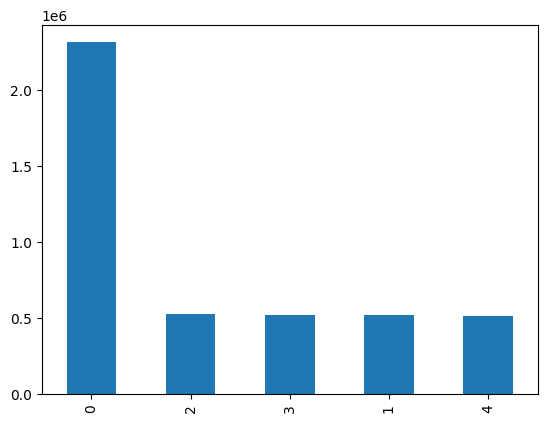

In [8]:
def show_value_counts():
    vc = y_train.stack().value_counts()
    vc.plot.bar()
    class_weights = []
    for counts in vc:
        class_weight = 1 - counts/vc.sum()
        class_weights.append(class_weight)
    return torch.Tensor(class_weights).to(device)
class_weights = show_value_counts()

In [9]:
def encode_y_one_hot():
    result_list = []
    for cl in range(num_class):
        arr_for_one_channel = (y_train == cl).values.astype(int)[:,:,np.newaxis]
        print(arr_for_one_channel.shape)
        print(np.unique(arr_for_one_channel, return_counts=True))
        result_list.append(arr_for_one_channel)
    y_oh = np.concatenate(result_list, axis=2)
    return y_oh

y_channeled = encode_y_one_hot()

(4000, 1100, 1)
(array([0, 1]), array([2086719, 2313281]))
(4000, 1100, 1)
(array([0, 1]), array([3879256,  520744]))
(4000, 1100, 1)
(array([0, 1]), array([3874624,  525376]))
(4000, 1100, 1)
(array([0, 1]), array([3877860,  522140]))
(4000, 1100, 1)
(array([0, 1]), array([3881541,  518459]))


In [10]:
def split_train_val(fold_idx=0):
    folds = KFold(n_splits=5, random_state=100, shuffle=True)
    indices= [(train_index, test_index) for (train_index, test_index) in folds.split(X_train.index)]
    train_index, val_index = indices[fold_idx]
    return train_index, val_index
train_index, val_index = split_train_val(2)

In [11]:
def show_dfy_channeled_vc():
    df_y = y_channeled[train_index]
    delimeter = 8
    n = round(df_y.shape[0]/delimeter)
    y = df_y[:n]
    for ch in range(y.shape[2]):
        print('train', ch, y[:,:,ch].sum())

    df_y = y_channeled[val_index]
    delimeter = 8
    n = round(df_y.shape[0]/delimeter)
    y = df_y[:n]
    for ch in range(y.shape[2]):
        print('val', ch, y[:,:,ch].sum())
show_dfy_channeled_vc()

train 0 229992
train 1 52014
train 2 52570
train 3 52724
train 4 52700
val 0 58343
val 1 12288
val 2 12503
val 3 13670
val 4 13196


In [12]:
class TabularDataset(Dataset):

    def __init__(self, df_x, df_y, df_y_oh, labeled):
        self.labeled = labeled
        self.n = df_x.shape[0]
        delimeter = 8
        self.part = round(self.n/delimeter)
        if (self.labeled):
            self.x = df_x[:self.part]
            self.y = df_y[:self.part]
            self.y_oh = df_y_oh[:self.part].transpose(0, 2, 1)
        else:
            self.x = df_x[self.part:]

    def __len__(self): return len(self.x)

    def __getitem__(self, idx):
        if (self.labeled):
            return [self.x[idx].astype(np.float32), self.y[idx], self.y_oh[idx]]
        else:
            return [self.x[idx].astype(np.float32), np.nan, np.nan]

In [13]:
batchsize = 16
trainset_l = TabularDataset(df_x=X_train.iloc[train_index].values,  df_y=y_train.iloc[train_index].values, df_y_oh=y_channeled[train_index], labeled=True)
trainset_u = TabularDataset(df_x=X_train.iloc[train_index].values,  df_y=y_train.iloc[train_index].values, df_y_oh=y_channeled[train_index], labeled=False)
trainloader_l = DataLoader(trainset_l, batchsize, shuffle=True, num_workers=0, drop_last=True)
trainloader_u = DataLoader(trainset_u, batchsize, shuffle=True, num_workers=0, drop_last=True)

valset = TabularDataset(df_x=X_train.iloc[val_index].values,  df_y=y_train.iloc[val_index].values, df_y_oh=y_channeled[val_index], labeled=True)
# valoader = DataLoader(valset, batchsize, shuffle=True, num_workers=2)
valoader = DataLoader(valset,batch_size=1)

In [14]:
generator = UNet(
    spatial_dims=1,
    in_channels=1,
    out_channels=num_class,
    channels=(1, 4, 8, 16, 32, 64, 128),
    strides=(1,1,1,1,1,1),
    num_res_units=3
).to(device)
optimG = torch.optim.Adam(generator.parameters(), 1e-3)

In [15]:
discriminator = UNet(
    spatial_dims=1,
    in_channels=num_class,
    out_channels=2,
    channels=(1, 4, 8, 16, 32, 64),
    strides=(1,1,1,1,1),
    num_res_units=1
).to(device)
optimD = torch.optim.Adam(discriminator.parameters(), 1e-3)

In [16]:
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=20000, power=0.9):
    """Polynomial decay of learning rate
        :param init_lr is base learning rate
        :param iter is a current iteration
        :param lr_decay_iter how frequently decay occurs, default is 1
        :param max_iter is number of maximum iterations
        :param power is a polymomial power
    """
    if iter % lr_decay_iter or iter > max_iter:
        return optimizer

    for param_group in optimizer.param_groups:
        param_group['lr'] = init_lr*(1 - float(iter)/max_iter)**power
    return optimizer

In [17]:
def calc_IoU_for_class(val_true_arg, val_preds_arg, cur_class):
    intersection = ((val_preds_arg==cur_class) * (val_true_arg==cur_class)).sum()
    union = ((val_preds_arg==cur_class).sum()+(val_true_arg==cur_class).sum()-intersection)
    IoU = intersection/union
    print(cur_class,'IoU',IoU)

In [18]:
def compare_1ch(y_gt_1ch, y_pred_1ch):
    print('acc',sum(y_gt_1ch == y_pred_1ch)/len(y_gt_1ch))
    print('f1',f1_score(y_gt_1ch, y_pred_1ch, average='macro'))
    cm = confusion_matrix(y_gt_1ch, y_pred_1ch)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


In [19]:
def draw_example(gt,pred):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 3))
    axes[0].plot(gt)
    axes[1].plot(pred)
    fig.tight_layout()
    plt.show()


In [20]:
def draw_example_2(signal,pred_mask, gt_mask):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), dpi=120)
    axes[0].plot(signal)
    axes[1].plot(signal)
    fig.show()

In [21]:
def draw_example_colored(signal,pred_mask, gt_mask):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 5), dpi=120)
    axes[0].plot(signal)
    axes[1].plot(signal)
    colors = ['k','g','r','y','m']
    for idx, (gt_mask_point, pred_mask_point) in enumerate(zip(gt_mask,pred_mask)):
        axes[0].axvspan(idx, idx+1, facecolor=colors[gt_mask_point], alpha=0.5)
        axes[1].axvspan(idx, idx+1, facecolor=colors[pred_mask_point], alpha=0.5)
    fig.show()

In [22]:
def remove_short(predicted):
    min_len = 5
    prev_elem = -1
    count_prev = 0
    predicted_counter = np.zeros_like(predicted)
    for idx, elem in enumerate(predicted):
        if (elem != prev_elem):
            prev_elem = elem
            count_prev = 0
        else:
            count_prev +=1
            predicted_counter[idx] = count_prev

    # print(predicted_counter)
    for idx in range(len(predicted_counter)):
        if(predicted_counter[idx] <= predicted_counter[idx-1]):
            if(predicted_counter[idx-1] <= min_len):
                for i in range(predicted_counter[idx-1]+1):
                    predicted[idx-1-i] = predicted[idx-1 - predicted_counter[idx-1] - 1]

    return np.array(predicted)


In [23]:
remove_short(np.array([1,1,1,1,2,2,3,3,3,3]))

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [33]:
def val(generator,valoader):
    generator.eval()
    hardpreds, masks = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
    for img_id, (img,mask,ohmask) in enumerate(valoader):
        img,mask,ohmask = img.unsqueeze(1).to(device).to(device), mask.to(device),ohmask.to(device)
        cpmap = generator(img) # N,C,L
        cpmapsmax = nn.Softmax(dim=1)(cpmap)
        cpmaplsmax = nn.LogSoftmax(dim=1)(cpmap)
        hardpred = torch.max(cpmaplsmax,1).indices.squeeze(1) # shape = N,L
        hardpreds = torch.cat([hardpreds, hardpred.view(-1)], 0)
        masks = torch.cat([masks, mask.view(-1)], 0)
        if img_id == random.randint(50,99):#to show random image, else would be same img
            break

    for cur_class in range(num_class):
        calc_IoU_for_class(hardpreds.detach().cpu().numpy(), masks.detach().cpu().numpy(), cur_class)

    # draw_example(hardpred.view(-1).detach().cpu().numpy(), mask.view(-1).detach().cpu().numpy())
    # draw_example_colored(img[0].view(-1).detach().cpu().numpy(), hardpred.view(-1).detach().cpu().numpy(), mask.view(-1).detach().cpu().numpy())
    compare_1ch(masks.detach().cpu().numpy(), hardpreds.detach().cpu().numpy())

    hardpreds_no_short = remove_short(hardpreds.detach().cpu().numpy().astype(int))
    draw_example_colored(img[0].view(-1).detach().cpu().numpy(), remove_short(hardpred.view(-1).detach().cpu().numpy().astype(int)), mask.view(-1).detach().cpu().numpy())
    # draw_example_2(img[0].view(-1).detach().cpu().numpy(), remove_short(hardpred.view(-1).detach().cpu().numpy().astype(int)), mask.view(-1).detach().cpu().numpy())
    compare_1ch(masks.detach().cpu().numpy(), hardpreds_no_short)


In [34]:
'''
    Snapshot the Best Model
'''
def snapshot(model,valoader,epoch,best_miou,snapshot_dir,prefix):
    miou = val(model,valoader)
    snapshot = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'miou': miou
    }
    if miou > best_miou:
        best_miou = miou
        torch.save(snapshot,os.path.join(snapshot_dir,'{}.pth.tar'.format(prefix)))

    print("[{}] Curr mIoU: {:0.4f} Best mIoU: {}".format(epoch,miou,best_miou))
    return best_miou

In [35]:
y_channeled.shape

(4000, 1100, 5)

In [36]:
start_epoch = 1 # TODO: 0
max_epoch = 100
lam_semi = 0.1 # Weight for Semi-supervised los
d_lr = 0.0001 # lr for discriminator
lam_adv = 0.01 # "Weight for Adversarial loss for Segmentation Network training"
g_lr = 0.00025 # lr for generator
wait_semi = 0 # Number of Epochs to wait before using semi-supervised loss
t_semi = 0.2 #Threshold for self-taught learning

In [37]:
class Seq2SeqRnn(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, output_size, num_layers=1, bidirectional=False, dropout=.3,
            hidden_layers = []):

        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.bidirectional=bidirectional
        self.output_size=output_size

        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                           bidirectional=bidirectional, batch_first=True,dropout=.3)

        self.hidden_layers = []
        self.output_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)

        self.activation_fn = torch.relu

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_len, self.input_size)
        outputs, (hidden, cell) = self.rnn(x)
        # print(x.shape, outputs.shape) #torch.Size([1, 1100, 1]) torch.Size([1, 1100, 256])
        x = self.dropout(self.activation_fn(outputs)) #torch.Size([1, 1100, 256])

        x = self.output_layer(x)
        x = torch.moveaxis(x, 2, 1)
        return x

[1][24]Loss: 1.5437
0 IoU 0.5380991735537191
1 IoU 0.0
2 IoU 0.0
3 IoU 0.0
4 IoU 0.0
acc 0.5380991735537191
f1 0.13993874590296063


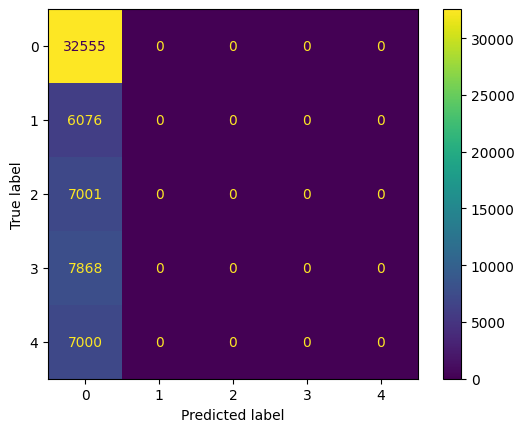

acc 0.5380991735537191
f1 0.13993874590296063


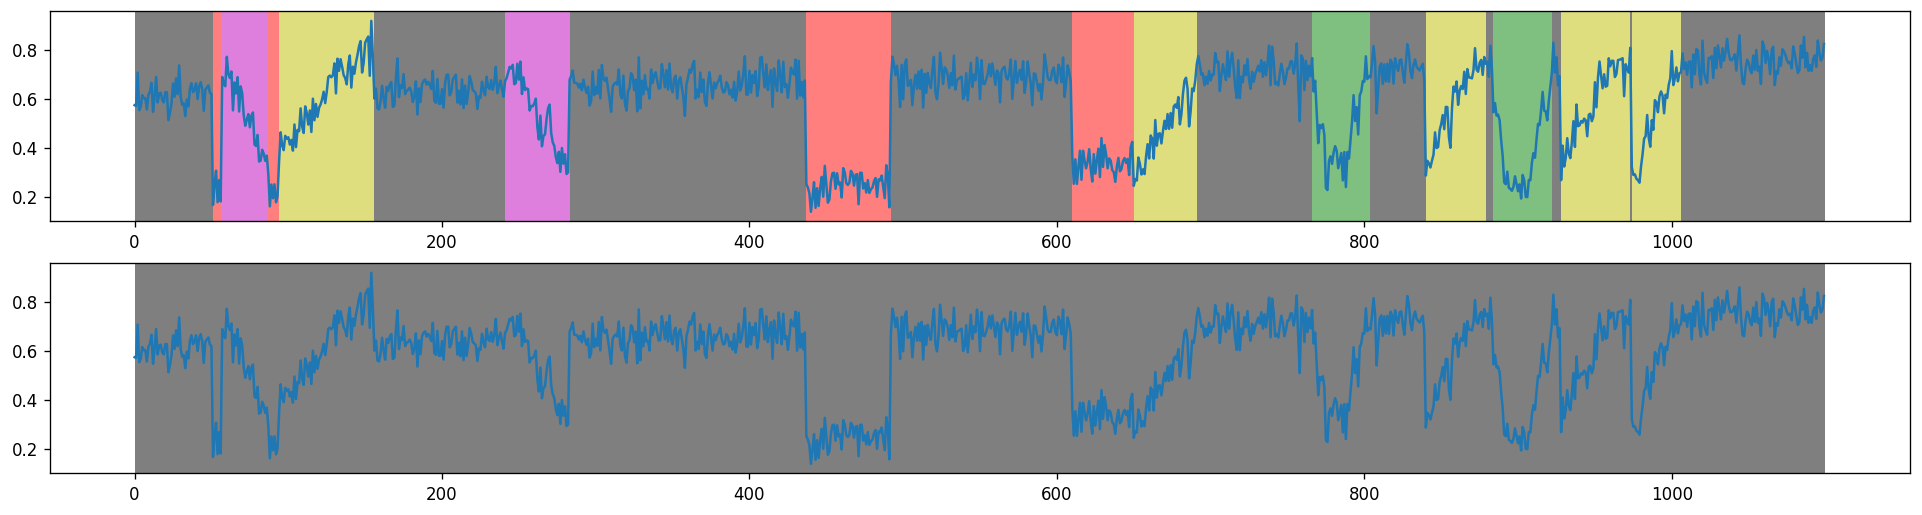

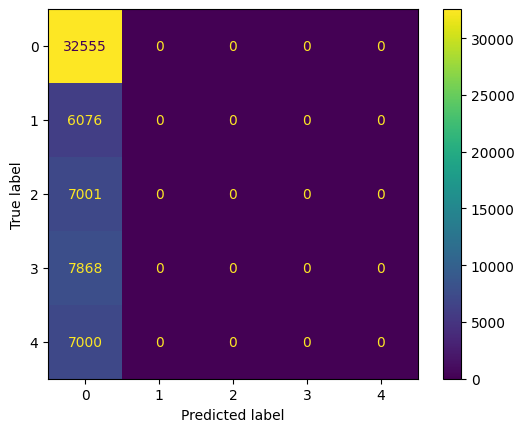

[2][49]Loss: 1.4652
[3][74]Loss: 1.3711
0 IoU 0.537123695976155
1 IoU 0.0
2 IoU 0.0
3 IoU 0.0
4 IoU 0.0
acc 0.537123695976155
f1 0.1397737078368447


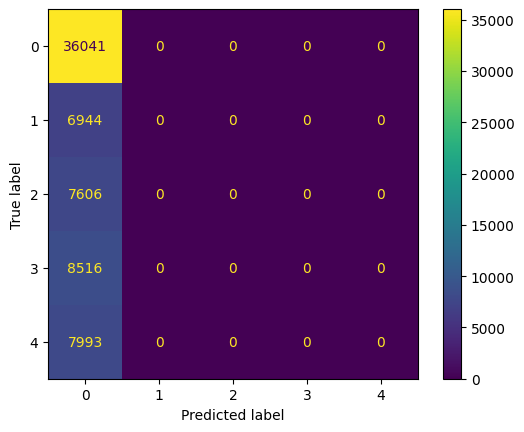

acc 0.537123695976155
f1 0.1397737078368447


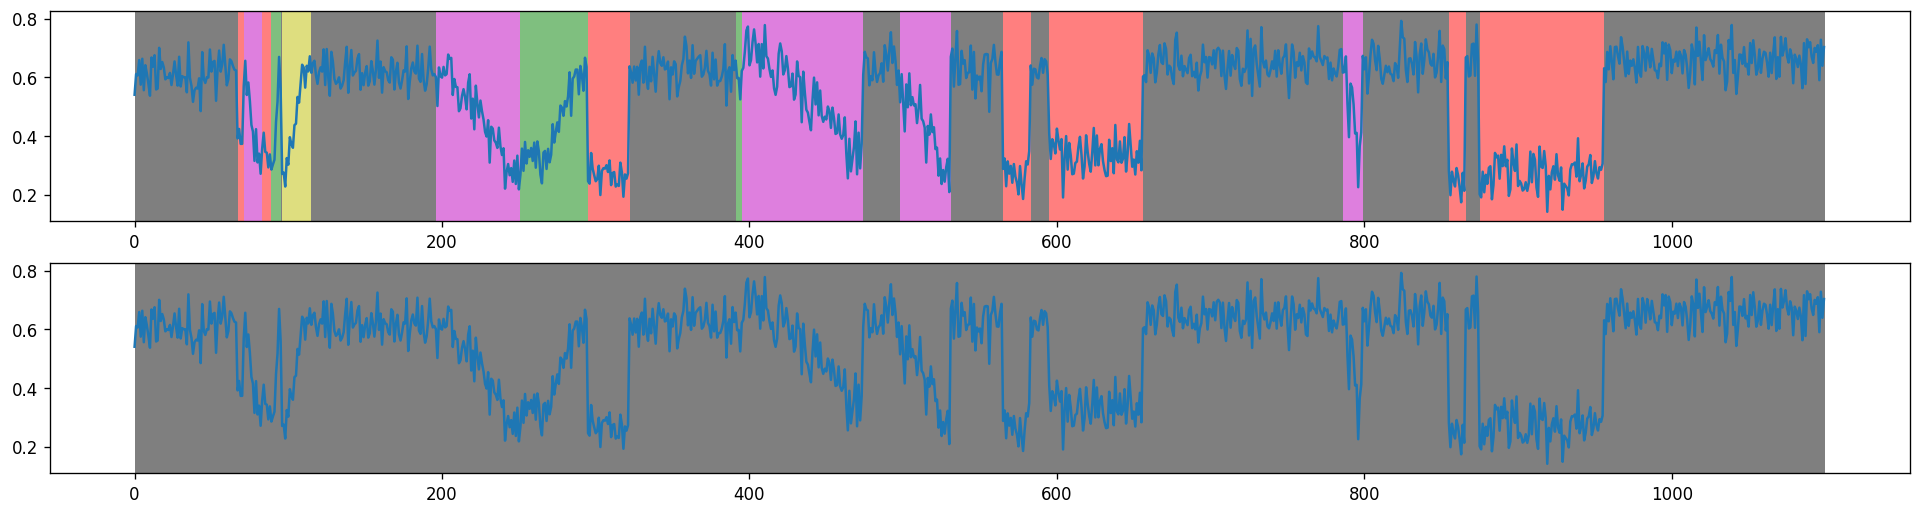

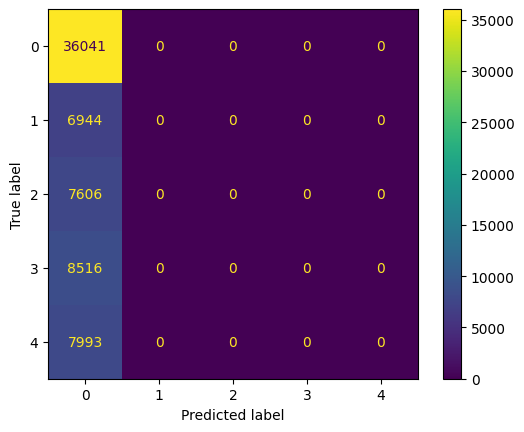

[4][99]Loss: 1.3060
[5][124]Loss: 1.2090
0 IoU 0.7014960140801325
1 IoU 0.03365490831430886
2 IoU 0.38775428479897484
3 IoU 0.18281822943949713
4 IoU 0.09017947421638019
acc 0.6296636363636363
f1 0.38461351116665454


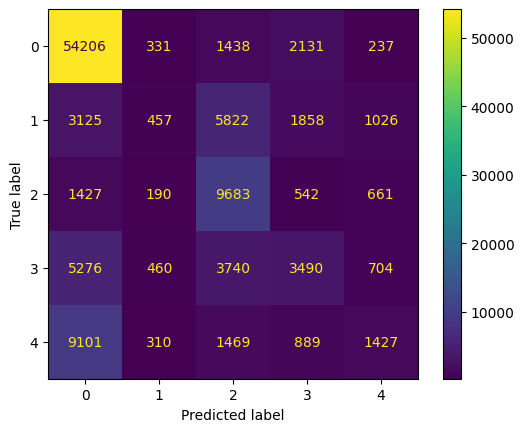

acc 0.627109090909091
f1 0.36890978937811125


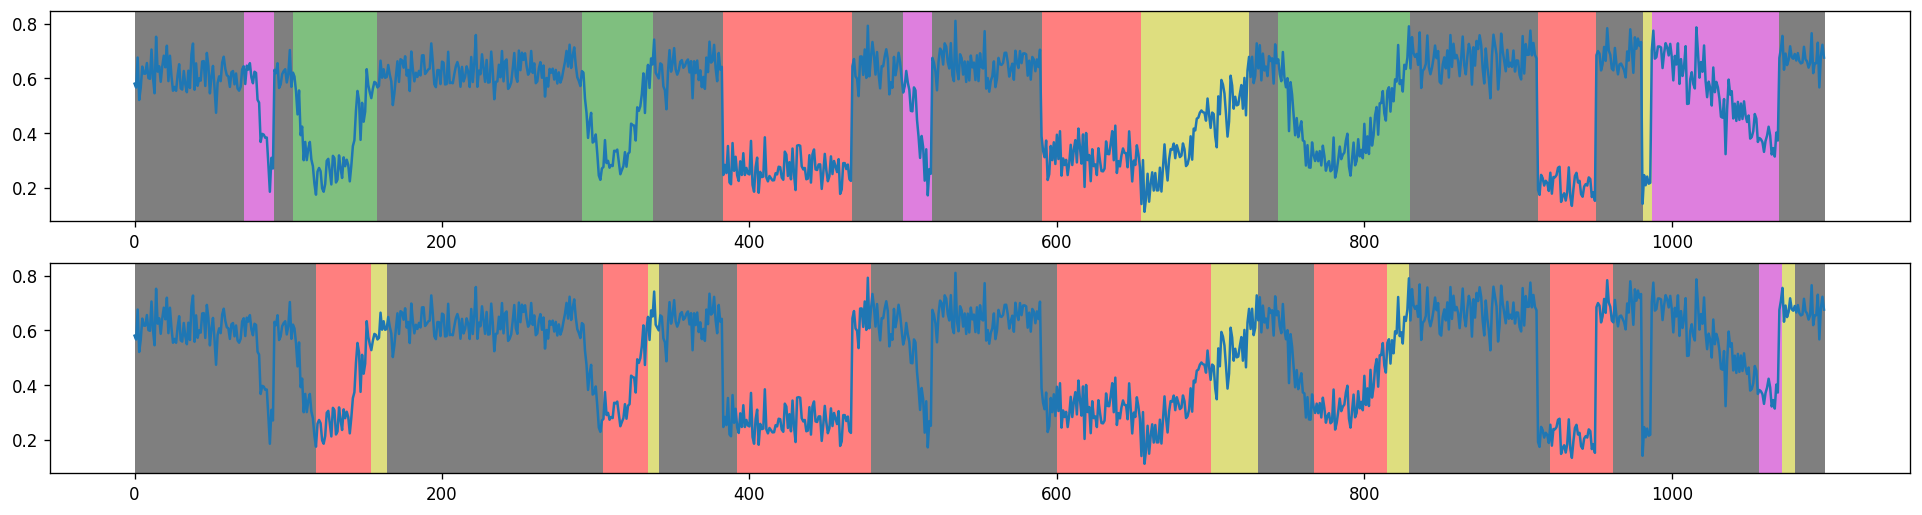

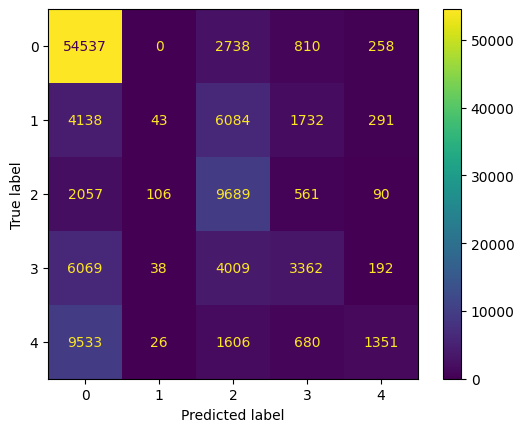

[6][149]Loss: 1.1189
[7][174]Loss: 1.1163
0 IoU 0.767966203983102
1 IoU 0.06612512469716403
2 IoU 0.4540983606557377
3 IoU 0.28674853372434017
4 IoU 0.33872976338729766
acc 0.705103668261563
f1 0.5138245465844157


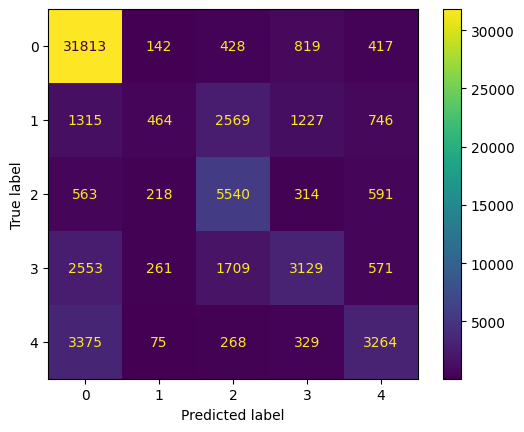

acc 0.7038277511961722
f1 0.5019036271517587


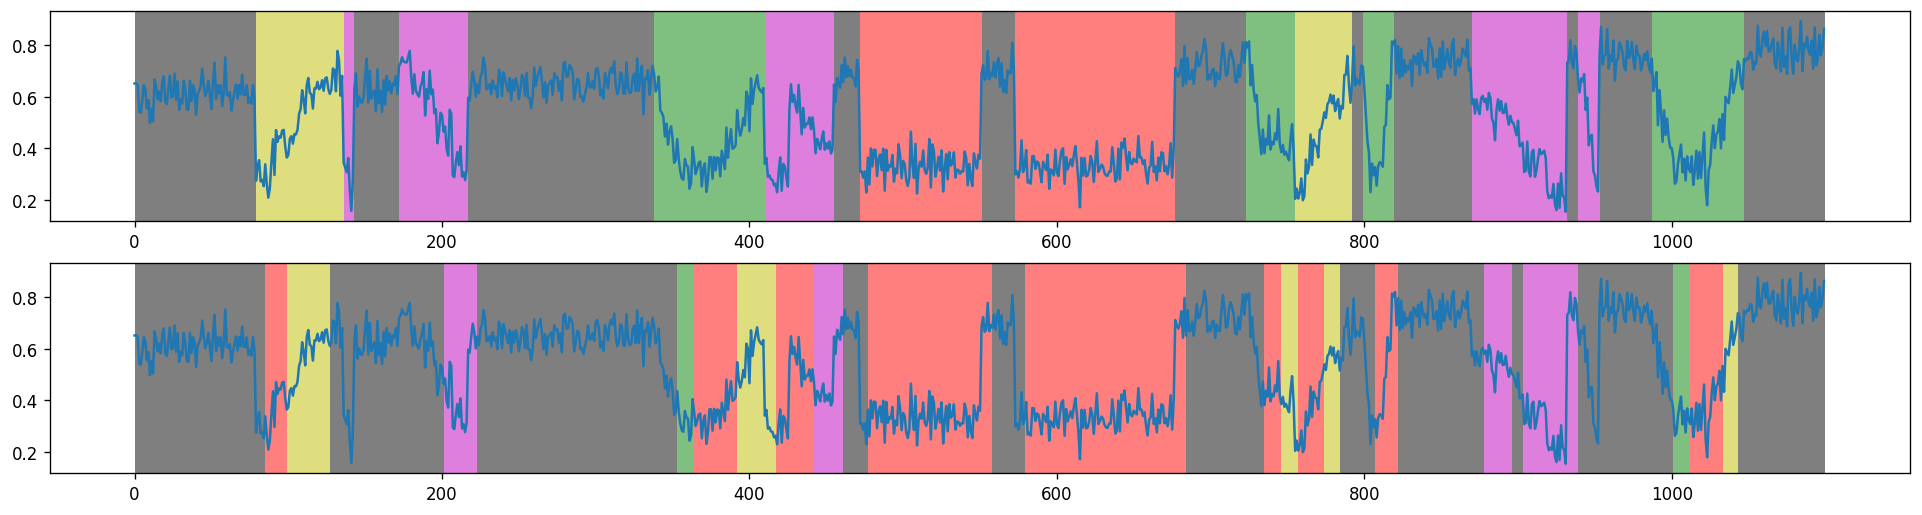

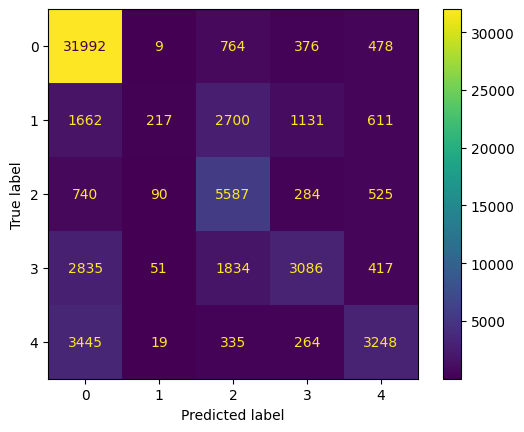

KeyboardInterrupt: ignored

In [38]:
def train_lstm(generator,optimG,trainloader,valoader):
    best_miou = -1
    for epoch in range(start_epoch,max_epoch+1):
        generator.train()
        for batch_id, (img,mask,_) in enumerate(trainloader):

            img,mask = img.unsqueeze(1).to(device).to(device), mask.to(device)

            itr = len(trainloader)*(epoch-1) + batch_id
            cprob = generator(img.detach())
            cprob = nn.LogSoftmax(dim=1)(cprob)
            Lseg = nn.NLLLoss(weight=class_weights)(cprob,mask)

            # cpmap = generator(img) # N,C,L
            cpmapsmax = nn.Softmax(dim=1)(cprob)
            cpmaplsmax = nn.LogSoftmax(dim=1)(cprob)
            hardpred = torch.max(cpmaplsmax,1).indices.squeeze(1) # shape = N,L

            optimG = poly_lr_scheduler(optimG, g_lr, itr)
            optimG.zero_grad()

            Lseg.backward()
            optimG.step()

        print("[{}][{}]Loss: {:0.4f}".format(epoch,itr,Lseg.detach()))

        if (epoch % 2):
            val(generator,valoader)

model=Seq2SeqRnn(input_size=1, seq_len=1100, hidden_size=256, output_size=5, num_layers=3, hidden_layers=[],
                 bidirectional=False).to(device) #bidirectional=True
optim = torch.optim.Adam(model.parameters(), 1e-3)
train_lstm(model,optim,trainloader_l,valoader)

[1][24]Loss: 1.5710
0 IoU 0.5071189216236297
1 IoU 0.20309183529078817
2 IoU 0.016506048800492105
3 IoU 0.12591674413800227
4 IoU 0.051600261267145654
acc 0.40464545454545453
f1 0.27297272744657464


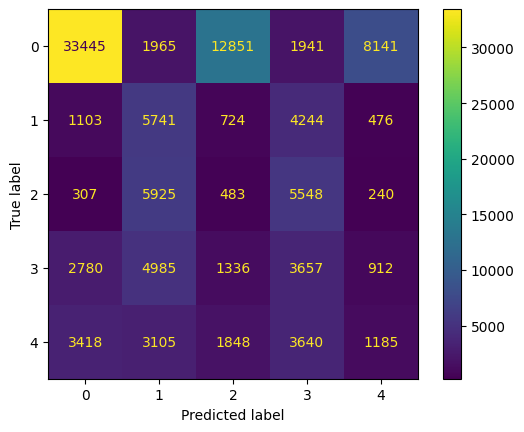

acc 0.4224818181818182
f1 0.20364786263276136


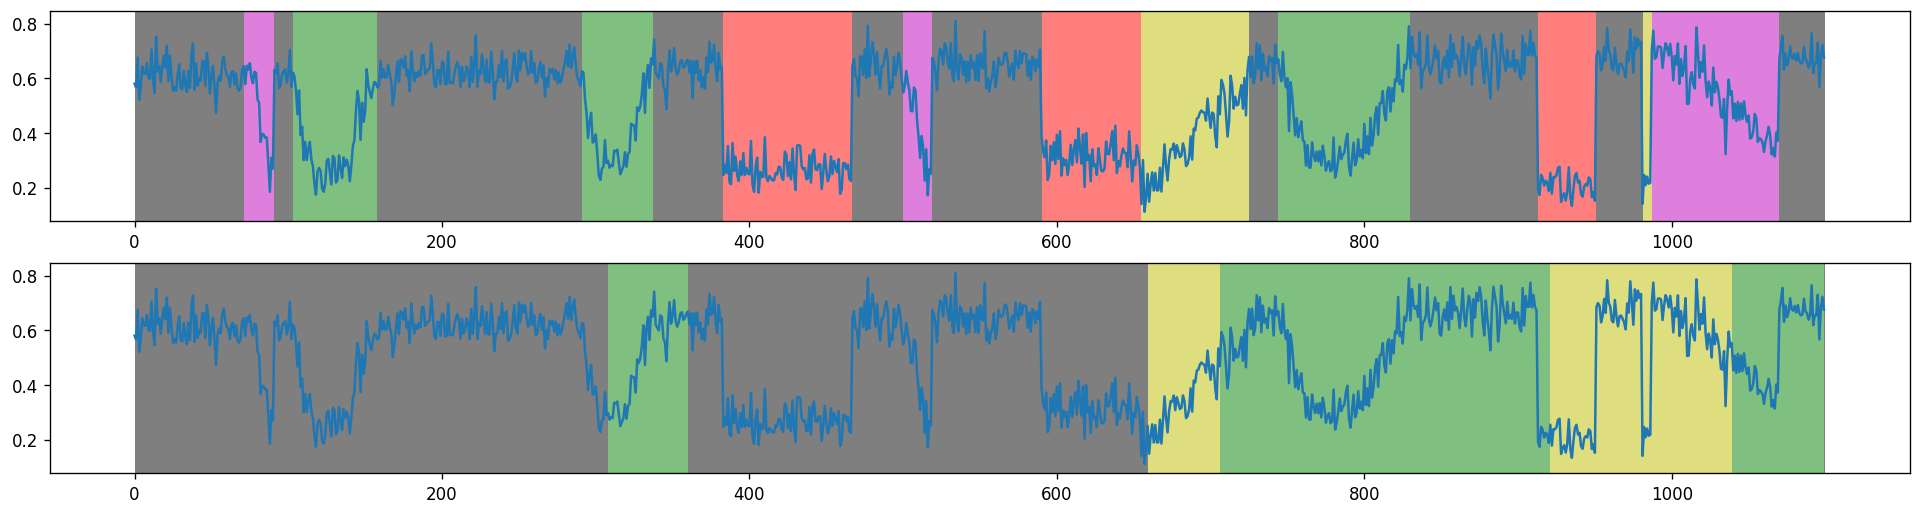

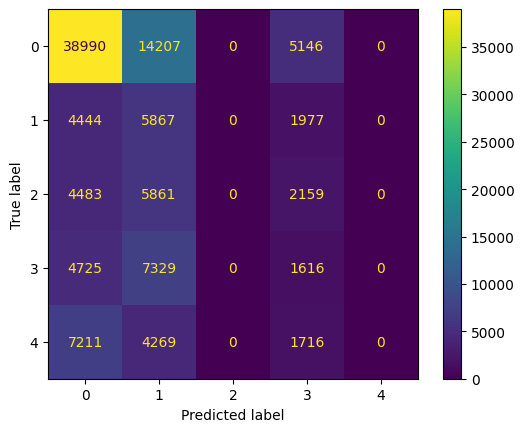

[2][49]Loss: 1.4986
[3][74]Loss: 1.4486
0 IoU 0.7142719772294556
1 IoU 0.2406600708800945
2 IoU 0.03562277357665146
3 IoU 0.09927373705009078
4 IoU 0.05287077715497652
acc 0.5383889528193325
f1 0.3142244732348017


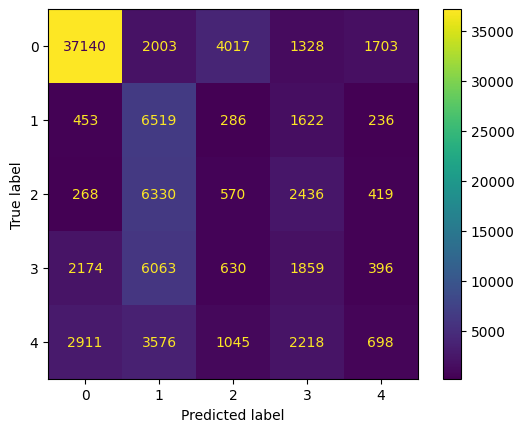

acc 0.5611737629459148
f1 0.24221863967682236


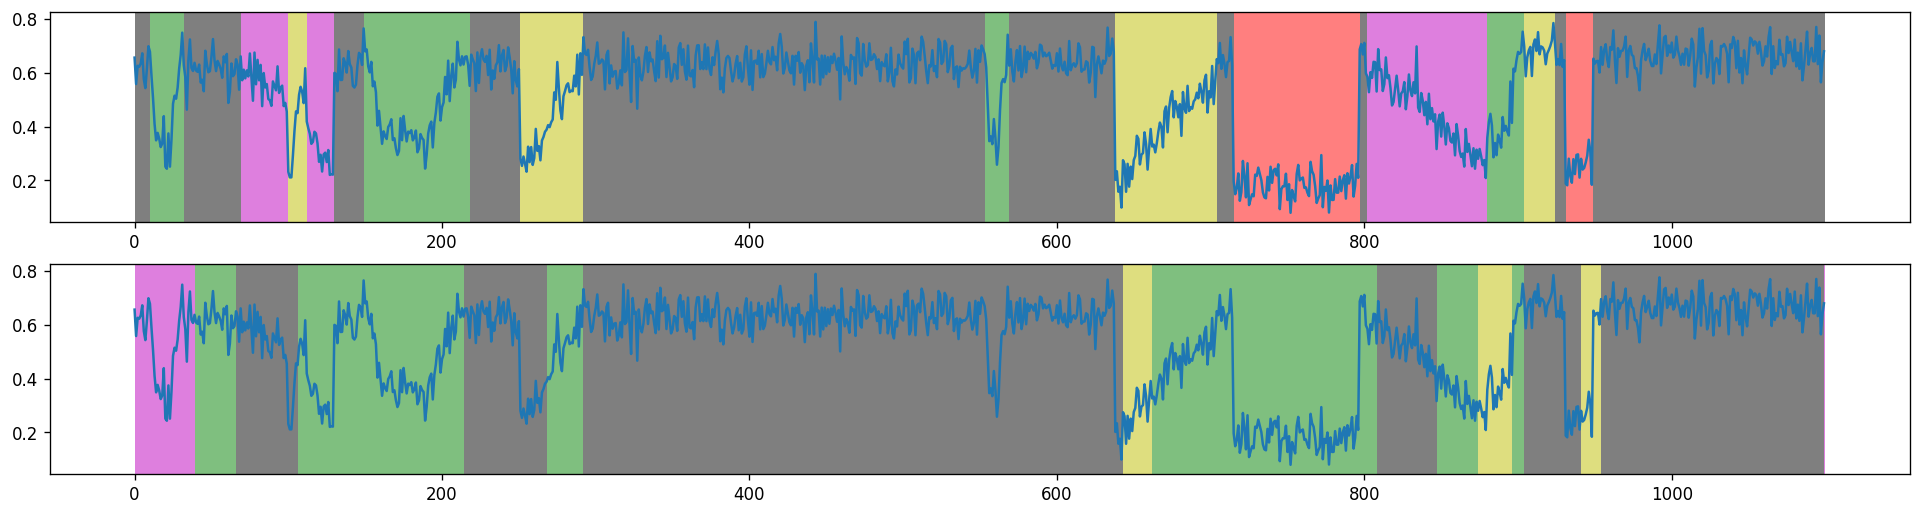

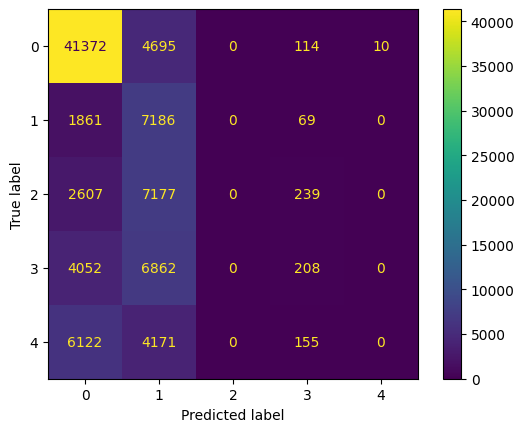

[4][99]Loss: 1.3646
[5][124]Loss: 1.3766
0 IoU 0.7718891839463623
1 IoU 0.2600732600732601
2 IoU 0.05327635327635328
3 IoU 0.08459894900964371
4 IoU 0.07540345019476906
acc 0.5782716049382716
f1 0.33628966560405305


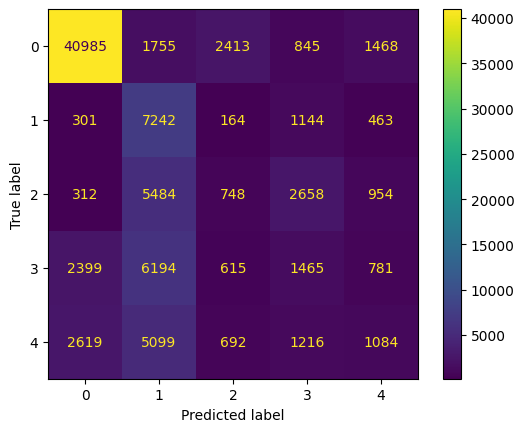

acc 0.5883838383838383
f1 0.2543001413761817


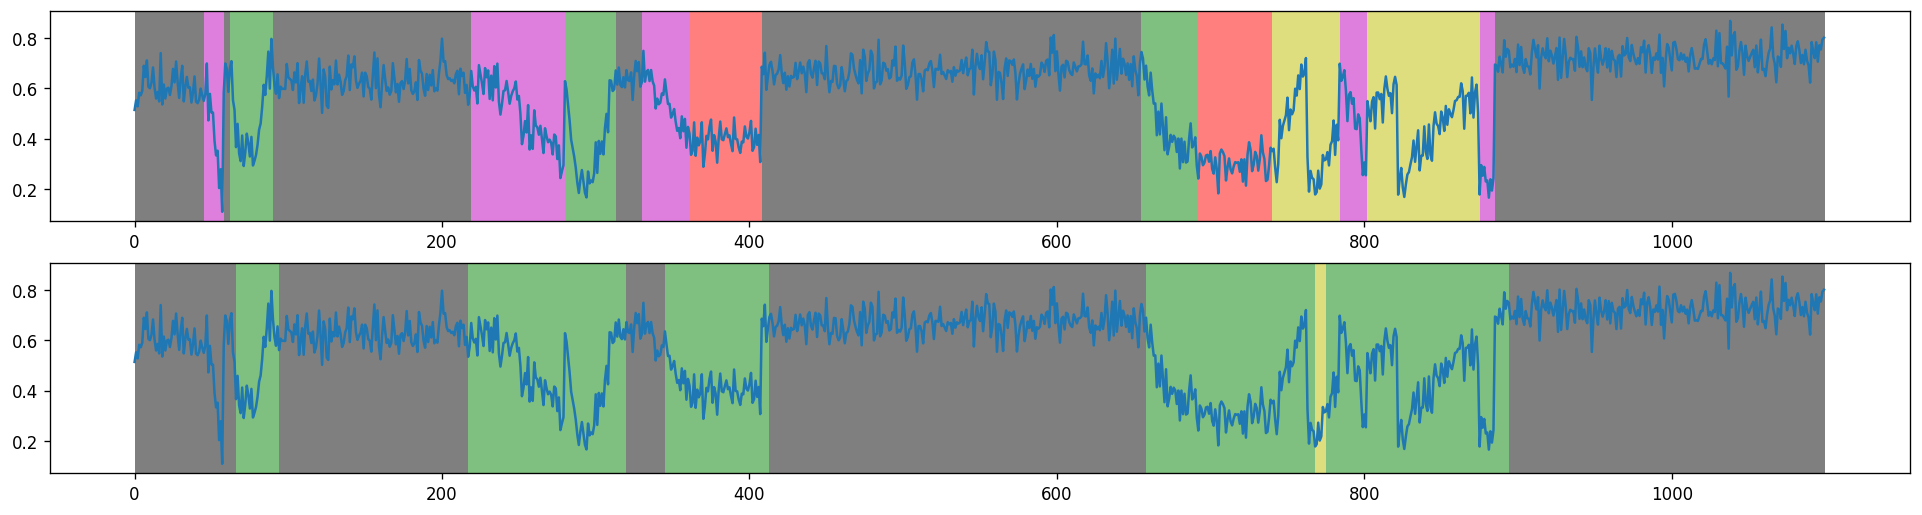

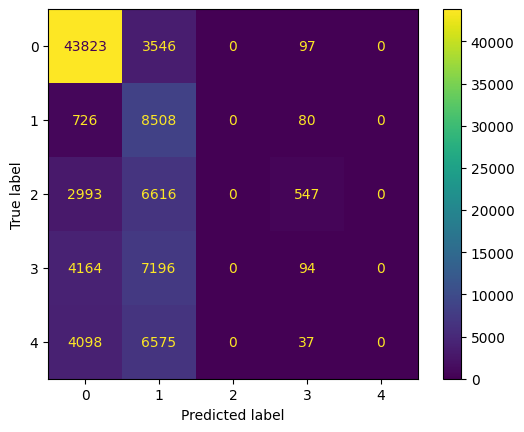

[6][149]Loss: 1.2855
[7][174]Loss: 1.2666
0 IoU 0.7957406204320285
1 IoU 0.2666478213463635
2 IoU 0.11700307902839549
3 IoU 0.05707513932483505
4 IoU 0.08766188553126306
acc 0.597769696969697
f1 0.35719147238988574


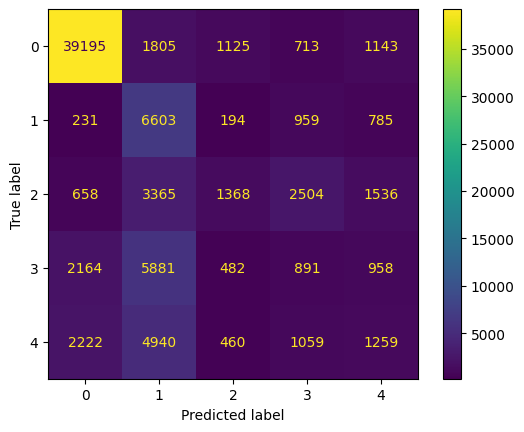

acc 0.5958424242424243
f1 0.2574446257025227


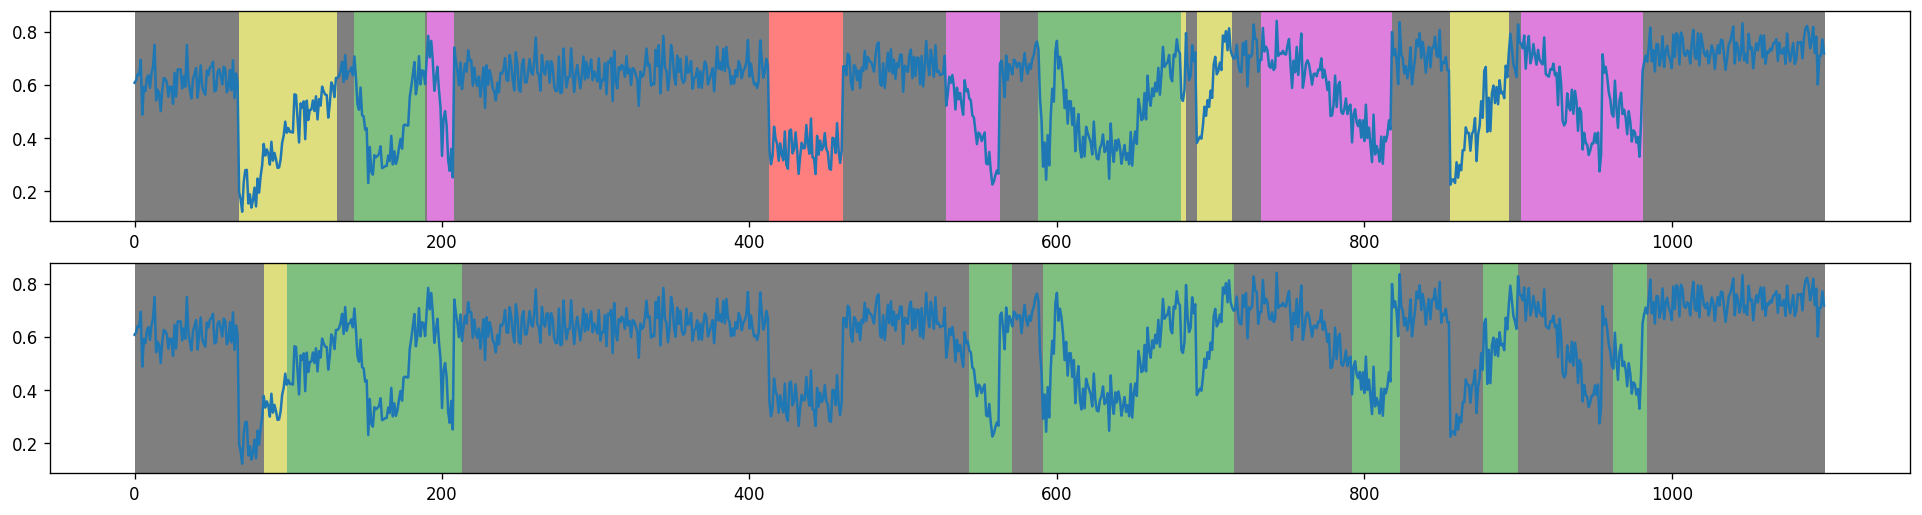

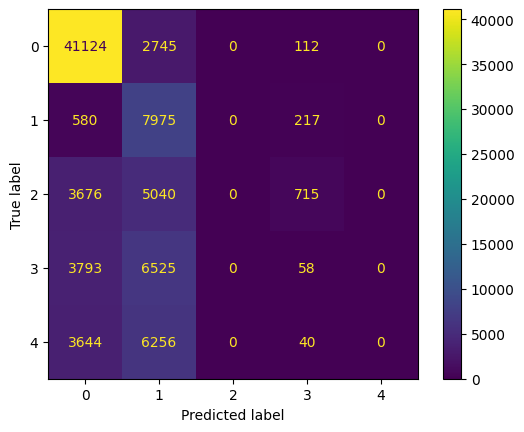

KeyboardInterrupt: ignored

In [39]:
def train_base(generator,optimG,trainloader,valoader):
    best_miou = -1
    for epoch in range(start_epoch,max_epoch+1):
        generator.train()
        for batch_id, (img,mask,_) in enumerate(trainloader):

            img,mask = img.unsqueeze(1).to(device), mask.to(device)

            itr = len(trainloader)*(epoch-1) + batch_id
            cprob = generator(img.detach())
            cprob = nn.LogSoftmax(dim=1)(cprob)
            Lseg = nn.NLLLoss(weight=class_weights)(cprob,mask)

            optimG = poly_lr_scheduler(optimG, g_lr, itr)
            optimG.zero_grad()

            Lseg.backward()
            optimG.step()

        print("[{}][{}]Loss: {:0.4f}".format(epoch,itr,Lseg.detach()))

        # best_miou = snapshot(generator,valoader,epoch,best_miou,args.snapshot_dir,args.prefix)
        if (epoch % 2):
            val(generator,valoader)

train_base(generator,optimG,trainloader_l,valoader)

In [ ]:
load = True
if (load):
    generator = torch.load('drive/MyDrive/Studies/Science/new_nir/code_4sem/monai/models/best_200e_generator05-01-2023-16-34-06', map_location=torch.device('cpu'))
    discriminator = torch.load('drive/MyDrive/Studies/Science/new_nir/code_4sem/monai/models/best_200e_discriminator05-01-2023-16-34-06', map_location=torch.device('cpu'))

In [ ]:

'''
    Semi supervised training
'''
def train_semi(generator,discriminator,optimG,optimD,trainloader_l,trainloader_u,valoader):
    best_miou = -1
    for epoch in range(start_epoch,max_epoch+1):
        generator.train()
        trainloader_l_iter = iter(trainloader_l)
        trainloader_u_iter = iter(trainloader_u)
        print("Epoch: {}".format(epoch))
        batch_id = 0
        # Randomly pick labeled or unlabeled data for training
        # strange mechanism of iteration because of random choice of iter (common practice for semi)
        while(True):
            p_labeled = random.random()
            # print('p_labeled',p_labeled)
            if p_labeled <0.5:
                loader = trainloader_l_iter
                labeled = True
            else:
                loader = trainloader_u_iter
                labeled = False
            # print(labeled)
            # Check if the loader has a batch available
            try:
                img,mask,ohmask = next(loader)
            except:
                # print("Curr loader doesn't have data")
                if labeled:
                    loader = trainloader_u_iter
                    labeled = False
                else:
                    loader = trainloader_l_iter
                    labeled = True

                # Check if the new loader has data
                try:
                    img,mask,ohmask = next(loader)
                except Exception as err:
                    print('Both loaders exhausted')
                    print(err)
                    break

            batch_id += 1
            img,mask,ohmask = img.unsqueeze(1).to(device).to(device), mask.to(device),ohmask.to(device)
            itr = (len(trainloader_u) + len(trainloader_l))*(epoch-1) + batch_id
            # print('LABELED?',labeled)
            if labeled:
                ################################################
                #  Labelled data for Discriminator Training #
                ################################################
                cpmap = generator(img.detach())
                cpmap = nn.Softmax(dim=1)(cpmap)

                N = cpmap.size()[0]
                C = cpmap.size()[1]
                L = cpmap.size()[2]

                # Generate the Real and Fake Labels
                targetf = torch.zeros((N,L)).long().to(device) #target for discriminator to mark fake. Zeros matrix (all pixels not confident)
                targetr = torch.ones((N,L)).long().to(device) #target for discriminator to mark real. Ones matrix (all pixels confident)

                # Train on Real
                confr = nn.LogSoftmax(dim=1)(discriminator(ohmask.float())) #confidence map for real. reakl = ohmask

                optimD.zero_grad()
                # print(confr.shape, targetr.shape)
                LDr = nn.NLLLoss()(confr,targetr) # confr = [10,2,321,321], targetr = [10,321,321]. 2 - two classes of confident or not.
                # targerr is not oh encoded as Loss get not oh, just indexes for truth parameter and logits for prediction parameter
                LDr.backward()

                # Train on Fake
                conff = nn.LogSoftmax(dim=1)(discriminator(cpmap.detach()))  # fake = generator output cpmap
                LDf = nn.NLLLoss()(conff,targetf)
                LDf.backward()

                # _d means detach
                LDr_d = LDr.detach()
                LDf_d = LDf.detach()
                LD_d = LDr_d + LDf_d
                optimD = poly_lr_scheduler(optimD, d_lr, itr)
                optimD.step()

                #####################################
                #  labelled data Generator Training #
                #####################################
                optimG.zero_grad()
                optimD.zero_grad()
                cpmap = generator(img)
                cpmaplsmax = nn.LogSoftmax(dim=1)(cpmap)

                conff = nn.LogSoftmax(dim=1)(discriminator(cpmaplsmax)) # fake = output of generator

                LGce = nn.NLLLoss(weight=class_weights)(cpmaplsmax,mask) # not oh encoded. Compare output of generator with mask
                LGadv = nn.NLLLoss()(conff,targetr) # compare closeness of discr output on gen output with ones matrix.
                #In simple check how good generator faked discrimjinator so that discr started to give ones
                # LGadv may stay same as generator is better at faking, and discriminator is better at finding fakes
                LGadv_d = LGadv.detach()
                LGce_d = LGce.detach()
                LGsemi_d = 0 # No semi-supervised training

                LGadv = lam_adv*LGadv

                (LGce + LGadv).backward()
                optimG = poly_lr_scheduler(optimG, g_lr, itr)
                optimG.step()

            else:
                #####################################
                # Use unlabelled data to get L_semi #
                #####################################
                # No discriminator training
                LD_d = 0
                LDr_d = 0
                LDf_d = 0
                # Init all loss to 0 for logging ease
                LGsemi_d = 0
                LGce_d = 0
                LGadv_d = 0
                optimG.zero_grad()
                if epoch > wait_semi: # wait usual train before semi
                    cpmap = generator(img)
                    cpmapsmax = nn.Softmax(dim=1)(cpmap)

                    conf = discriminator(cpmapsmax)
                    confsmax = nn.Softmax(dim=1)(conf) #shape = N,2,L, where 2 is confident_prob/notconfident_prob classes
                    conflsmax = nn.LogSoftmax(dim=1)(conf)

                    N = cpmap.size()[0]
                    C = cpmap.size()[1]
                    L = cpmap.size()[2]

                    # Adversarial Loss
                    targetr = torch.ones((N,L)).long().to(device)

                    LGadv = nn.NLLLoss()(conflsmax,targetr) # check how good discr found fakes of generator. Compare not found fakes (confident as real = 1) with ones matrix.
                    LGadv_d = LGadv.detach()
                    # Semi-Supervised Loss

                    hardpred = torch.max(cpmapsmax,1).indices.squeeze(1) # shape = N,L # same as argmax
                    idx = np.zeros(cpmap.data.cpu().numpy().shape,dtype=np.uint8)
                    idx = idx.transpose(0, 2, 1) # shape = N,L,C

                    confnp = confsmax[:,1,...].detach().cpu().numpy()#shape = N,L. 1 - take confident class from 2 # same as argmax from confmap (where 2 classes)
                    hardprednp = hardpred.detach().cpu().numpy()
                    idx[confnp > t_semi] = np.identity(num_class, dtype=idx.dtype)[hardprednp[ confnp > t_semi]]

                    # here confnp > args.t_semi are pixels that are larger than treshold (same matrix as confnp, but boolean instead of numbers (numbers from 0 to 1))
                    # hardprednp[confnp > args.t_semi] is a 1d list of values from matrix hardprednp, that corresponds to positions from prev bool matrix
                    # idx[confnp > args.t_semi] is also a list of values of matrix idx from positions that correspond to bool matrix
                    # idx values get hardpred values, but instead of raw hardred values ONE HOT encoded value
                    # one hot value we get as next: value = 5, identity(21)[5] = [0,0,0,0,1,0,....0]
                    # so idx has 4th dimension of size C
                    # idx has shape [N,H,W,C] and if pixel is > t_semi then it is onehot vector, else it is zeros vector

                    LG = lam_adv*LGadv
                    if np.count_nonzero(idx) != 0:
                        cpmaplsmax = nn.LogSoftmax(dim=1)(cpmap)
                        idx = torch.from_numpy(idx.transpose(0,2,1)).to(device, dtype=bool) #from NCL to NLC
                        LGsemi_arr = cpmaplsmax.masked_select(idx)
                        # selected only those in whom we are convinced. One class of convinced pixel, if no confident then just zeros.
                        # then we calculate how many pixels are confident
                        # the more pixels confident the higher mean, -1 means we want to minimize anti high mean, same as maximize high mean

                        LGsemi = -1*LGsemi_arr.mean()
                        LGsemi_d = LGsemi.detach()
                        LGsemi = lam_semi*LGsemi
                        LG += LGsemi

                    LG.backward()
                    optimG = poly_lr_scheduler(optimG, g_lr, itr)
                    optimG.step()
                    # Manually free all variables. Look into details of how variables are freed
                    del idx
                    del confnp
                    del confsmax
                    del hardpred
                    del hardprednp
                    del cpmapsmax
                    del cpmap
            LGseg_d = LGce_d + LGadv_d + LGsemi_d # is not being minimized. Used only for visualization of total loss


            # Manually free memory! Later, really understand how computation graphs free variables

        print("[{}][{}] LD: {:.4f} LD_fake: {:.4f} LD_real: {:.4f} LG: {:.4f} LG_ce: {:.4f} LG_adv: {:.4f} LG_semi: {:.4f}"\
                .format(epoch,itr,LD_d,LDr_d,LDf_d,LGseg_d,LGce_d,LGadv_d,LGsemi_d))
        if (epoch % 2):
            val(generator,valoader)
        # best_miou = snapshot(generator,valoader,epoch,best_miou,args.snapshot_dir,args.prefix)

train_semi(generator,discriminator,optimG,optimD,trainloader_l,trainloader_u,valoader)

Epoch: 1


KeyboardInterrupt: ignored

In [ ]:
now = datetime.now() # current date and time
date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
date_time

In [ ]:
torch.save(generator, 'drive/MyDrive/Studies/Science/new_nir/code_4sem/monai/models/generator'+date_time)
torch.save(discriminator, 'drive/MyDrive/Studies/Science/new_nir/code_4sem/monai/models/discriminator'+date_time)

In [ ]:
# state = {
#     'epoch': epoch,
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
#     ...
# }
# torch.save(state, filepath)

In [ ]:
# model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])